# Import necessary libraries

In [48]:
import os
import numpy as np
import pandas as pd
import shutil
import random
from skimage import color, io, feature, exposure
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix,roc_curve,auc
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score,StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder,label_binarize
from sklearn.decomposition import PCA
import seaborn as sns
from itertools import cycle

# Function to extract HOG features from an image 

In [9]:
# Function to extract HOG features from an image and visualize it
def extract_hog_features(image):
    # Calculate HOG features
    hog_features, hog_image  = feature.hog(image, orientations=8, pixels_per_cell=(16, 16),
    cells_per_block=(1, 1), visualize=True, channel_axis=-1)

    # Enhance the contrast of the HOG image for better visualization
    hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

    return hog_features, hog_image_rescaled

# Define dataset path and showing image and feature extracted

HOG Features Shape for 0022d6b7-d47c-4ee2-ae9a-392a53f48647___JR_B.Spot 8964.JPG: (2048,)


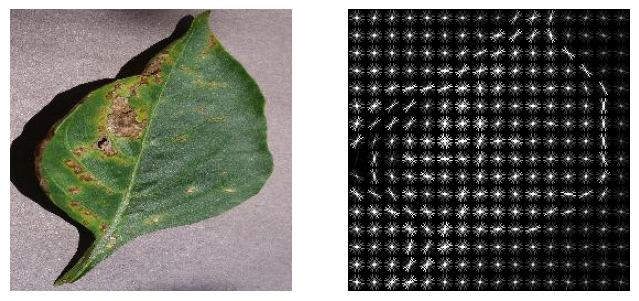

HOG Features Shape for 001187a0-57ab-4329-baff-e7246a9edeb0___RS_Early.B 8178.JPG: (2048,)


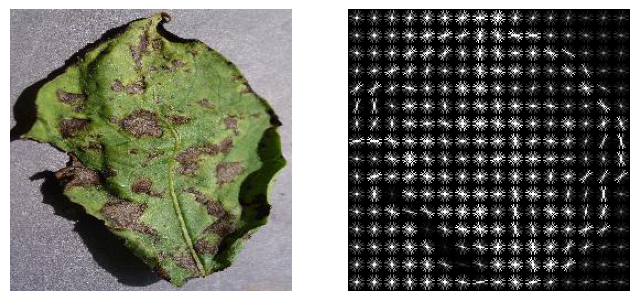

HOG Features Shape for 0051e5e8-d1c4-4a84-bf3a-a426cdad6285___RS_LB 4640.JPG: (2048,)


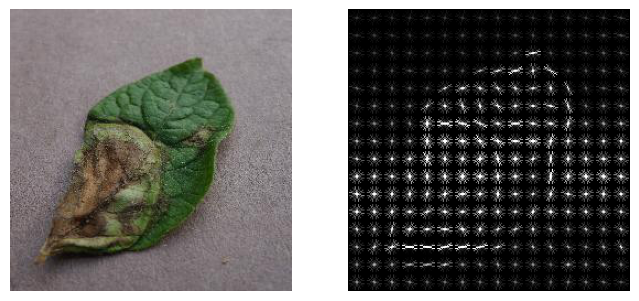

In [42]:
dataset_path = 'leafesv2'
# List all subdirectories (assuming each subdirectory corresponds to a class)
class_folders = [f.path for f in os.scandir(dataset_path) if f.is_dir()]
images=[]
features_list=[]
img_name =[]
labels_list=[]

# Loop through each class folder
for class_folder in class_folders:
    class_name = os.path.basename(class_folder)

# Loop through each image in the class folder
    
    for inx,image_filename in enumerate(os.listdir(class_folder)):
        if inx==1:
            break
            
        image_path = os.path.join(class_folder, image_filename)

        # Load the image
        image = io.imread(image_path)

        # Extract HOG features and visualize
        hog_features, hog_image = extract_hog_features(image)

        # Print the dimensions of the HOG features
        print(f"HOG Features Shape for {image_filename}: {hog_features.shape}")

        # Display the original image and the HOG features
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

        ax1.axis('off')
        ax1.imshow(image, cmap=plt.cm.gray)

        ax2.axis('off')
        ax2.imshow(hog_image, cmap=plt.cm.gray)

        plt.show()

        
        # Append HOG features to the features list
        features_list.append(hog_features)
        images.append(image)
        img_name.append(image_path)

        # Append the label to the labels list
        labels_list.append(class_name)

# Convert lists to NumPy arrays and reshape

In [33]:
image_data = np.array(images).reshape(len(images), -1)
print(image_data.shape)


(2997, 196608)


# convert labels to numeric labels

In [34]:
# x
features_array =image_data
# y
labels_array = np.array(labels_list)
# Use LabelEncoder to convert class names into numeric labels
label_encoder = LabelEncoder()
# y_encoded
numeric_labels = label_encoder.fit_transform(labels_array)
print(features_array)
print(numeric_labels)

[[109  94  97 ... 170 157 166]
 [139 125 148 ... 128 113 134]
 [155 140 159 ... 195 186 203]
 ...
 [136 124 128 ... 135 124 130]
 [144 133 137 ... 181 179 184]
 [108  95 104 ... 143 139 156]]
[0 0 0 ... 2 2 2]


# Split the dataset into training and testing sets

In [35]:
X_train, X_test, y_train, y_test = train_test_split(features_array,numeric_labels,test_size=0.3,random_state=42)

# Standardize the image data

In [36]:
scaler = StandardScaler()
X_train= scaler.fit_transform(X_train)
X_test= scaler.transform(X_test)

In [37]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(2097, 196608) (900, 196608) (2097,) (900,)


# Train Logistic Regression model

In [38]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

# Evaluate the model on the test set

In [44]:
y_pred =model.predict(X_test)
accuracy = accuracy_score(y_test,y_pred)
print(f"Accuracy: {accuracy:.2f}")
print('Accuracy on test Data :',round(accuracy*100,2),'%')

Accuracy: 0.83
Accuracy on test Data : 83.44 %


# printing classification report

In [45]:
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

                               precision    recall  f1-score   support

Pepper__bell___Bacterial_spot       0.88      0.73      0.80       312
        Potato___Early_blight       0.91      0.90      0.90       277
         Potato___Late_blight       0.75      0.88      0.81       311

                     accuracy                           0.83       900
                    macro avg       0.85      0.84      0.84       900
                 weighted avg       0.84      0.83      0.83       900



# Plot ROC curves for each class

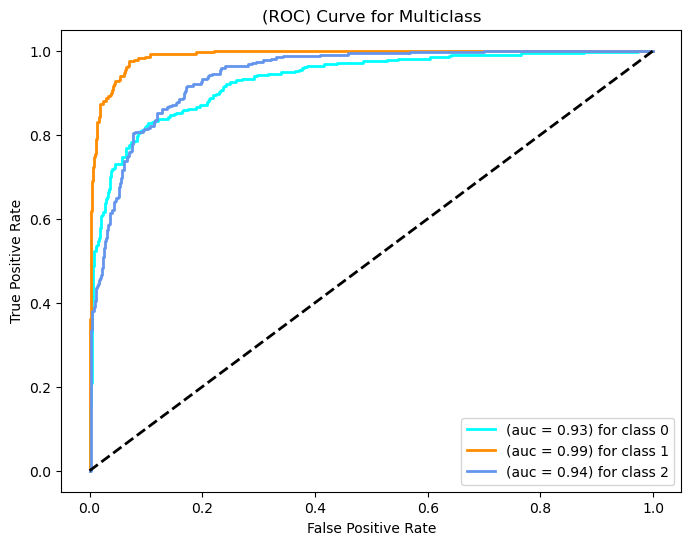

In [49]:
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))

# Calculate ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

# Get the number of classes
n_classes = y_test_bin.shape[1]
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], model.predict_proba(X_test)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for each class
plt.figure(figsize=(8, 6))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label='(auc = {:.2f}) for class {}'.format(roc_auc[i], i))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('(ROC) Curve for Multiclass')
plt.legend(loc='lower right')
plt.show()


# Plot Confusion Matrix

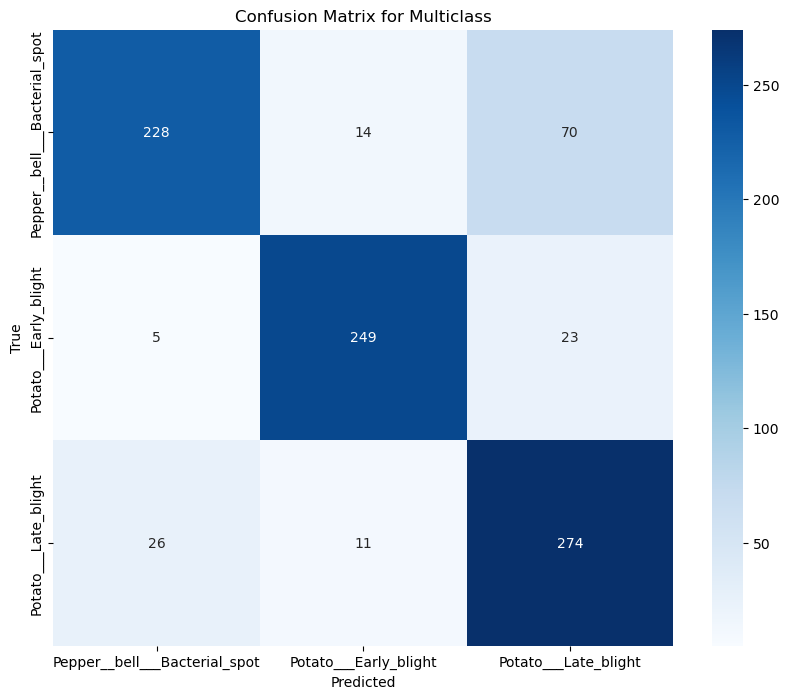

In [56]:
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Multiclass')
plt.show()


# calculating cross validation

In [17]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_score_log=cross_val_score(model,features_array,labels_list,cv=cv)
mean_acc=np.mean(cv_score_log)
print("Cross-Validation Scores:", cv_score_log)
print("Mean Accuracy:", mean_acc)

Cross-Validation Scores: [0.82833333 0.85166667 0.84140234 0.83806344 0.83472454]
Mean Accuracy: 0.8388380634390652
